In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import folium 
import requests

from  matplotlib import pyplot as plt
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from keras import models, layers, optimizers, regularizers
from keras.callbacks.callbacks import EarlyStopping

from folium.plugins import HeatMap
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/src/script.ipynb
/kaggle/lib/kaggle/gcp.py
/kaggle/lib/kaggle/competitions/twosigmanews/__init__.py
/kaggle/lib/kaggle/competitions/twosigmanews/env.py
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/working/__output__.json
/kaggle/working/__notebook__.ipynb


In [2]:
TRAIN_PATH = '/kaggle/input/new-york-city-taxi-fare-prediction/train.csv'
TEST_PATH = '/kaggle/input/new-york-city-taxi-fare-prediction/test.csv'

# Objetivos
#### Realizar a leitura com um pequeno conjunto de dados para idetificarmos como os próximos passos devem ser feitos
#### Pré-procesamento.
#### Engenharia de features.
#### Gerar um novo arquivo contendo as aterações.

# Lendo os dados de treino
Os dados de treinos são tão extensos que a plataforma Kaggle não suporta dizer quantas linhas ele têm, para isso, usaremos o seguinte método para realizar a leitura dos dados:

In [3]:
%%time
# Método escrito por @szelee
with open(TRAIN_PATH) as file:
    n_rows = len(file.readlines())

print (f'Exact number of rows: {n_rows}')

Exact number of rows: 55423857
CPU times: user 16.2 s, sys: 15.7 s, total: 31.9 s
Wall time: 32.6 s


Como podemos observar, existe um grande número de linhas.
Por enquanto vamos ler apenas um pequeno conjunto de dados.

In [4]:
trainDf = pd.read_csv(TRAIN_PATH, nrows=50_000)
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
key                  50000 non-null object
fare_amount          50000 non-null float64
pickup_datetime      50000 non-null object
pickup_longitude     50000 non-null float64
pickup_latitude      50000 non-null float64
dropoff_longitude    50000 non-null float64
dropoff_latitude     50000 non-null float64
passenger_count      50000 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


In [5]:
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
key                  50000 non-null object
fare_amount          50000 non-null float64
pickup_datetime      50000 non-null object
pickup_longitude     50000 non-null float64
pickup_latitude      50000 non-null float64
dropoff_longitude    50000 non-null float64
dropoff_latitude     50000 non-null float64
passenger_count      50000 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


In [6]:
trainDf.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


# Preprocessamento dos dados


Podemos perceber que existem linhas nas quais existem valores nulos, como latitude e longitude, como possuimos dados em abundânncia, podemos simplesmente excluir essas linhas. Também exluiremos linhas duplicadas.

In [7]:
trainDf.dropna(inplace=True)
trainDf.drop_duplicates(inplace=True)

In [8]:
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 8 columns):
key                  50000 non-null object
fare_amount          50000 non-null float64
pickup_datetime      50000 non-null object
pickup_longitude     50000 non-null float64
pickup_latitude      50000 non-null float64
dropoff_longitude    50000 non-null float64
dropoff_latitude     50000 non-null float64
passenger_count      50000 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.4+ MB


In [9]:
trainDf.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734371,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


A partir desses dados podemos perceber que existem algums dados discrepantes como
* viagem que custou 500US  ou  -44US (valor negativo).
* Coordenadas muito longe de Nova York
* viagem que levou 208 passageiros

Começaremos com o custo da viagem.

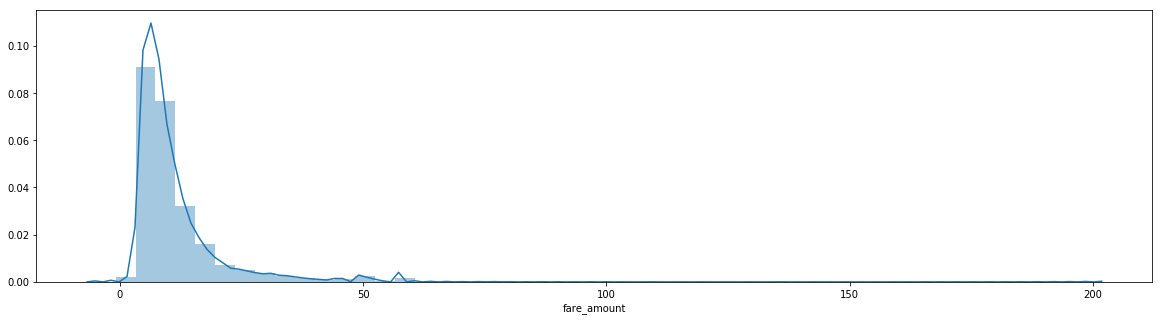

In [10]:
plt.figure(figsize=(20,5))
sns.distplot(trainDf['fare_amount']);

In [11]:
print('Quantidade de viagens com custo negativo: {}'.format((trainDf['fare_amount'][trainDf['fare_amount'] <= 2.5]).shape[0]))
print('Quantidade de viagens com custo acima do normal: {}'.format((trainDf['fare_amount'][trainDf['fare_amount'] > 80]).shape[0]))
print('Quantidade de viagens com custo normal: {}'.format((trainDf['fare_amount'][trainDf['fare_amount'] > 2.5][trainDf['fare_amount'] < 80]).shape[0]))

Quantidade de viagens com custo negativo: 213
Quantidade de viagens com custo acima do normal: 44
Quantidade de viagens com custo normal: 49743


A partir de uma pesquisa, descobri que o valor mínimo de uma passagem de táxi é US$ 2,50

A partir deste gráfico e dessas informações definiremos que os valores fora de 2,50 e 80,00 serão outliers

In [12]:
trainDf = trainDf[trainDf['fare_amount'].between(2.5, 80)]
trainDf.shape

(49946, 8)

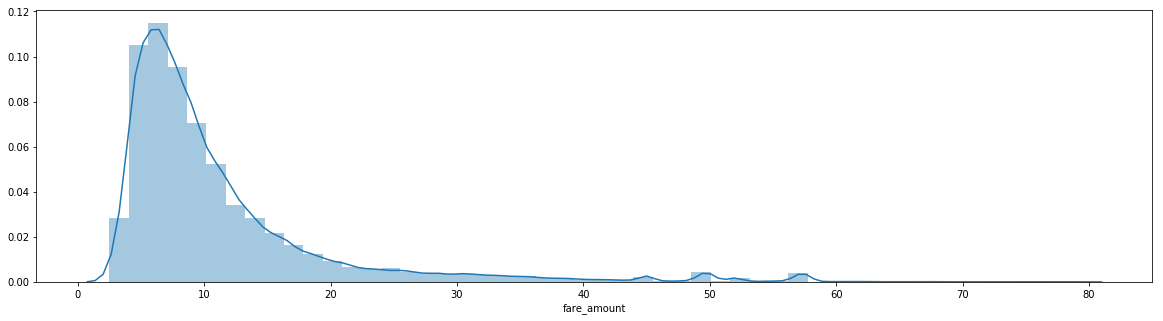

In [13]:
plt.figure(figsize=(20,5))
sns.distplot(trainDf['fare_amount']);

Agora o resultado está bem melhor

#### Fazendo o mesmo procedimento para os outros campos
Coodenadas: Longitude

In [14]:
# a formação de uma cordenada é feita por por uma latitude e uma longitude -> coord(latitude, longitude)
coordenadaMedia = (40.75, -73.9) #Coordenadas fornecidas pelo google
coordenadaMedia 

(40.75, -73.9)

In [15]:
foliumLimitation = trainDf[:30000]
foliumLimitation = foliumLimitation[['dropoff_latitude', 'dropoff_longitude']].apply(tuple, axis=1)

In [16]:
mapaDeCalor = folium.Map(coordenadaMedia, zoom_start=10, width='100%', height='100%')
mapaDeCalor.add_child(HeatMap(foliumLimitation, radius=10))
folium.PolyLine([(-100, -74.2),(100, -74.2)], color="black").add_to(mapaDeCalor)
folium.PolyLine([(-100, -73.6),(100, -73.6)], color="black").add_to(mapaDeCalor)
folium.PolyLine([(41, -100),(41, 100)], color="black").add_to(mapaDeCalor)
folium.PolyLine([(40.45, -100),(40.45, 100)], color="black").add_to(mapaDeCalor)
mapaDeCalor 

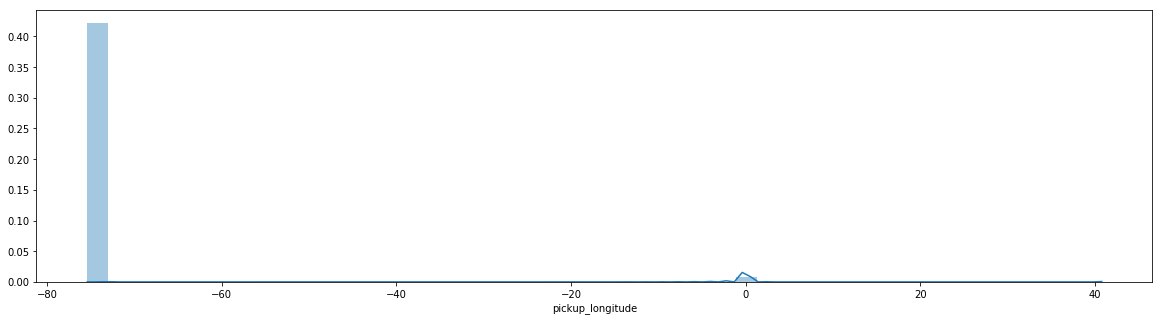

In [17]:
#pickup_longitude
plt.figure(figsize=(20,5))
sns.distplot(trainDf['pickup_longitude']);

In [18]:
print('pickup_longitude muito para a esquerda: {}'.format((trainDf['pickup_longitude'][trainDf['pickup_longitude'] <= -74.2]).shape[0]))
print('pickup_longitude muito para direita: {} '.format((trainDf['pickup_longitude'][trainDf['pickup_longitude'] > -73.6]).shape[0]))
print('pickup_longitude normal: {}'.format((trainDf['pickup_longitude'][trainDf['pickup_longitude'] > -74.2][trainDf['pickup_longitude'] < -73.6]).shape[0]))

pickup_longitude muito para a esquerda: 14
pickup_longitude muito para direita: 1002 
pickup_longitude normal: 48930


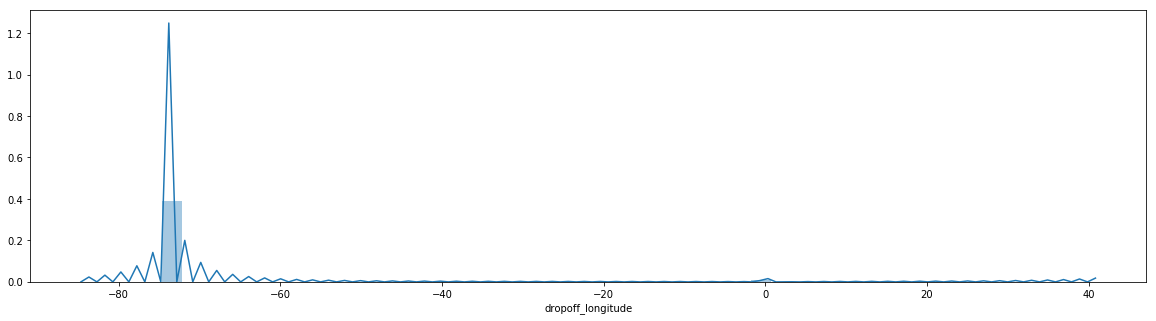

In [19]:
# dropoff_longitude
plt.figure(figsize=(20,5))
sns.distplot(trainDf['dropoff_longitude']);

In [20]:
print('dropoff_longitude muito abaixo do normal: {}'.format((trainDf['dropoff_longitude'][trainDf['dropoff_longitude'] <= -74.2]).shape[0]))
print('dropoff_longitude muito acima do normal: {} '.format((trainDf['dropoff_longitude'][trainDf['dropoff_longitude'] > -73.6]).shape[0]))
print('dropoff_longitude normal: {}'.format((trainDf['dropoff_longitude'][trainDf['dropoff_longitude'] > -74.2][trainDf['dropoff_longitude'] < -73.6]).shape[0]))

dropoff_longitude muito abaixo do normal: 14
dropoff_longitude muito acima do normal: 1000 
dropoff_longitude normal: 48932


Aplicando apenas aos valores normais:

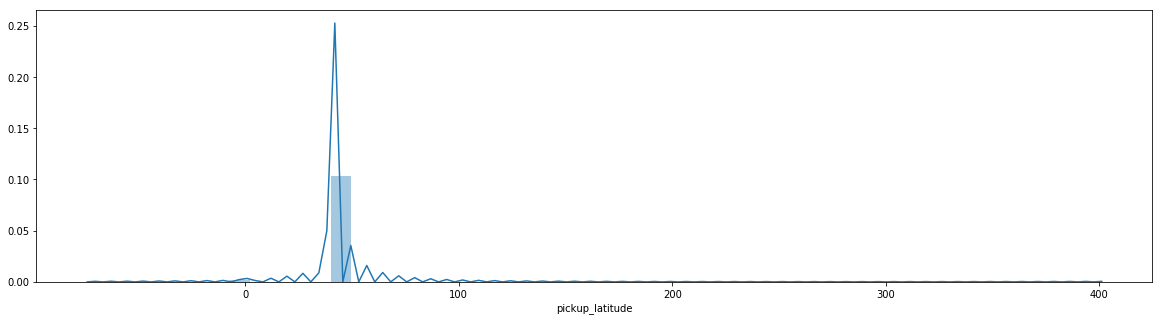

In [21]:
# pickup_latitude
plt.figure(figsize=(20,5))
sns.distplot(trainDf['pickup_latitude']);

In [22]:
print('pickup_latitude muito abaixo do normal: {}'.format((trainDf['pickup_latitude'][trainDf['pickup_latitude'] < 40.5]).shape[0]))
print('pickup_latitude muito acima do normal: {} '.format((trainDf['pickup_latitude'][trainDf['pickup_latitude'] > 41]).shape[0]))
print('pickup_latitude normal: {}'.format((trainDf['pickup_latitude'][trainDf['pickup_latitude'] > 40.45][trainDf['pickup_latitude'] < 41]).shape[0]))

pickup_latitude muito abaixo do normal: 991
pickup_latitude muito acima do normal: 25 
pickup_latitude normal: 48931


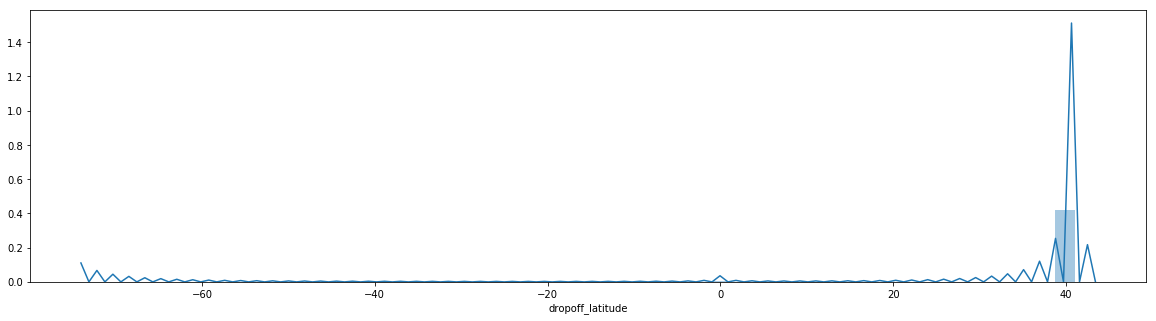

In [23]:
# dropoff_latitude
plt.figure(figsize=(20,5))
sns.distplot(trainDf['dropoff_latitude']);

In [24]:
print('dropoff_latitude muito abaixo do normal: {}'.format((trainDf['dropoff_latitude'][trainDf['dropoff_latitude'] < 40.5]).shape[0]))
print('dropoff_latitude muito acima do normal: {} '.format((trainDf['dropoff_latitude'][trainDf['dropoff_latitude'] > 41]).shape[0]))
print('dropoff_latitude normal: {}'.format((trainDf['dropoff_latitude'][trainDf['dropoff_latitude'] > 40.45][trainDf['dropoff_latitude'] < 41]).shape[0]))

dropoff_latitude muito abaixo do normal: 989
dropoff_latitude muito acima do normal: 19 
dropoff_latitude normal: 48940


In [25]:
trainDf = trainDf[trainDf['pickup_longitude'].between(-74.2, -73.6)]
trainDf = trainDf[trainDf['dropoff_longitude'].between(-74.2, -73.6)]
trainDf = trainDf[trainDf['pickup_latitude'].between(40.5, 41)]
trainDf = trainDf[trainDf['dropoff_latitude'].between(40.5, 41)]
trainDf.shape

(48850, 8)

#### passenger_count
Sabemos que normalmente o táxi pode levar no máximo 4 passageiros. 

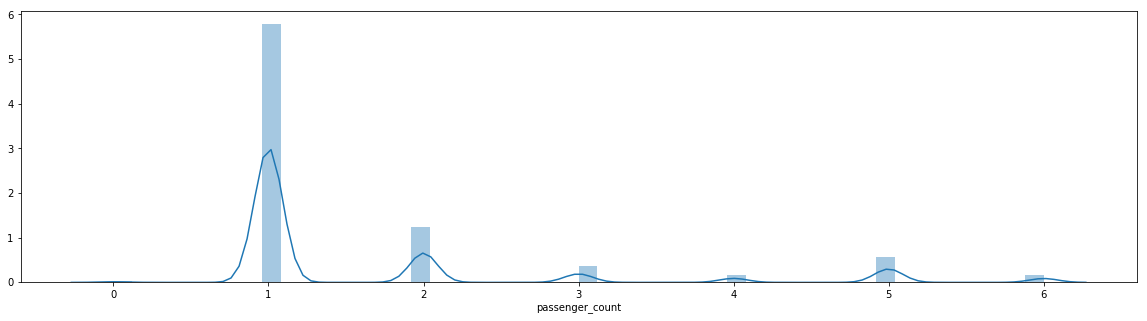

In [26]:
plt.figure(figsize=(20,5))
sns.distplot(trainDf['passenger_count']);

In [27]:
print('passenger_count muito abaixo do normal: {}'.format((trainDf['passenger_count'][trainDf['passenger_count'] == 0]).shape[0]))
print('passenger_count muito acima do normal: {} '.format((trainDf['passenger_count'][trainDf['passenger_count'] > 4]).shape[0]))
print('passenger_count normal: {}'.format((trainDf['passenger_count'][trainDf['passenger_count'] > 0][trainDf['passenger_count'] < 5]).shape[0]))

passenger_count muito abaixo do normal: 159
passenger_count muito acima do normal: 4351 
passenger_count normal: 44340


O que é um passageiro?. considere os seguintes cenários:
 - 4 pessoas mais dois bebês de colo. são 6 passageiros? 4?
 - O taxísta foi entregar uma encomenda a alguem. podemos considerar uma viagem válida mesmo não havendo passageiro
 
Iremos deixar essa coluna da maneira que está.

# Engenharia de Features.

### Irei criar dois tipos de features:
1. Features de tempo
    * Ano 
    * mês 
    * dia 
    * hora 
    * dia da semana  
    
2. Features de distância
    * Haversine distance

In [28]:
# transformando a pickup_datetime para o formato adequado (datetime)
trainDf['pickup_datetime'] =  pd.to_datetime(trainDf['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z')

In [29]:
# Adicionando as features de tempo
trainDf['year'] = trainDf['pickup_datetime'].apply(lambda x: x.year)
trainDf['month'] = trainDf['pickup_datetime'].apply(lambda x: x.month)
trainDf['day'] = trainDf['pickup_datetime'].apply(lambda x: x.day)
trainDf['hour'] = trainDf['pickup_datetime'].apply(lambda x: x.hour)
trainDf['weekday'] = trainDf['pickup_datetime'].apply(lambda x: x.weekday())

In [30]:
trainDf.drop(columns=['pickup_datetime'], inplace=True)
trainDf.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,0
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,1
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,3
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,5
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,1


In [31]:
trainDf.values[0, 1], 

(4.5,)

In [32]:
trainDf['haversine'] = trainDf.apply(lambda x: haversine_distances([
    [ x['pickup_latitude'], x['pickup_longitude'] ],
    [ x['dropoff_latitude'],x['dropoff_longitude']]
])[0, 1], axis=1)

In [33]:
trainDf.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,haversine
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,0,0.009430
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,1,0.079617
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,3,0.013655
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,5,0.025337
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,1,0.019455


# Transformando o datatest de teste e gerando um novo csv

In [34]:
df_test = pd.read_csv(TEST_PATH)
df_test['pickup_datetime'] = df_test['pickup_datetime'].str.slice(0, 16)
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')    
    
df_test['year'] = df_test['pickup_datetime'].apply(lambda x: x.year)
df_test['month'] = df_test['pickup_datetime'].apply(lambda x: x.month)
df_test['day'] = df_test['pickup_datetime'].apply(lambda x: x.day)
df_test['hour'] = df_test['pickup_datetime'].apply(lambda x: x.hour)
df_test['weekday'] = df_test['pickup_datetime'].apply(lambda x: x.weekday())
    
df_test['haversine'] = df_test.apply(lambda x: haversine_distances([
    [ x['pickup_latitude'], x['pickup_longitude'] ],
    [ x['dropoff_latitude'],x['dropoff_longitude']]
])[0, 1], axis=1)
    
df_test.drop(columns=['pickup_datetime'], inplace=True)
    

In [35]:
df_test.to_csv('test_prep.csv')

# Transformando o datatest de treino e gerando um novo csv, usando apenas 10 milhões de linhas

Para que possamos melhorar a velocidade da leitura dos dados e do processamento do algoritmo transformaremos todos os float64 em float32, para isso:

In [36]:
traintypes = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

cols = list(traintypes.keys())

In [37]:
train_df = pd.read_csv(TRAIN_PATH, usecols=cols, dtype=traintypes, nrows=10_000_000)

In [38]:
%%time
# Pre-processamento
train_df.dropna(inplace=True)
train_df.drop_duplicates(inplace=True)
train_df = train_df[train_df['fare_amount'].between(2.5, 80)]
train_df = train_df[train_df['pickup_longitude'].between(-74.2, -73.6)]
train_df = train_df[train_df['dropoff_longitude'].between(-74.2, -73.6)]
train_df = train_df[train_df['pickup_latitude'].between(40.5, 41)]
train_df = train_df[train_df['dropoff_latitude'].between(40.5, 41)]

CPU times: user 25.5 s, sys: 4.18 s, total: 29.7 s
Wall time: 28.9 s


In [39]:
%%time
#Engenharia de features
train_df['pickup_datetime'] = train_df['pickup_datetime'].str.slice(0, 16)
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')    

CPU times: user 9.96 s, sys: 784 ms, total: 10.7 s
Wall time: 10.6 s


In [40]:
%%time
train_df['year'] = train_df['pickup_datetime'].apply(lambda x: x.year)
train_df['month'] = train_df['pickup_datetime'].apply(lambda x: x.month)
train_df['day'] = train_df['pickup_datetime'].apply(lambda x: x.day)
train_df['hour'] = train_df['pickup_datetime'].apply(lambda x: x.hour)
train_df['weekday'] = train_df['pickup_datetime'].apply(lambda x: x.weekday())

CPU times: user 1min 25s, sys: 1.86 s, total: 1min 27s
Wall time: 1min 27s


In [41]:
%%time
train_df['haversine'] = train_df.apply(lambda x: haversine_distances([
    [x.pickup_latitude , x.pickup_longitude],
    [x.dropoff_latitude, x.dropoff_longitude]])[0, 1], axis=1)

train_df.drop(columns=['pickup_datetime'], inplace=True)

CPU times: user 43min 54s, sys: 11.5 s, total: 44min 5s
Wall time: 44min 5s


In [42]:
train_df.reset_index().to_feather('train_prep10M.feather')
del train_df

Os arquivos ".feather" são aquivos que podem ser gravados e lidos de forma super rápida pelo pandas

### Lendo 55 milhões de linhas, realizamos todo o preprocesamento e adição de novas features.

Este processo dura em torno de 4 horas

In [43]:
# %%time
# # Primeiramente iremos definir a quantidade de dados que queremos lêr por vez:
# chunksize = 50_000 # Defini como 5 milhões de cada vez
# listDf = [] # lista que irá receber as partes do dataframe
# for df_chunk in tqdm(pd.read_csv(TRAIN_PATH, usecols=cols, dtype=traintypes, chunksize=chunksize)):
#     #Pre-processamento
    
#     df_chunk = df_chunk[df_chunk['fare_amount'].between(2.5, 80)]
#     df_chunk = df_chunk[df_chunk['pickup_longitude'].between(-74.2, -73.6)]
#     df_chunk = df_chunk[df_chunk['dropoff_longitude'].between(-74.2, -73.6)]
#     df_chunk = df_chunk[df_chunk['pickup_latitude'].between(40.5, 41)]
#     df_chunk = df_chunk[df_chunk['dropoff_latitude'].between(40.5, 41)]
    
#     #Engenharia de features
    
#     df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
#     df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')    
    
#     df_chunk['year'] = df_chunk['pickup_datetime'].apply(lambda x: x.year)
#     df_chunk['month'] = df_chunk['pickup_datetime'].apply(lambda x: x.month)
#     df_chunk['day'] = df_chunk['pickup_datetime'].apply(lambda x: x.day)
#     df_chunk['hour'] = df_chunk['pickup_datetime'].apply(lambda x: x.hour)
#     df_chunk['weekday'] = df_chunk['pickup_datetime'].apply(lambda x: x.weekday())
    
#     df_chunk['haversine'] = df_chunk.apply(lambda x: haversine_distances([
#         [ x['pickup_latitude'], x['pickup_longitude'] ],
#         [ x['dropoff_latitude'],x['dropoff_longitude']]
#     ])[0, 1], axis=1)
    
#     df_chunk.drop(columns=['pickup_datetime'], inplace=True)
    
#     listDf.append(df_chunk) 

# trainDf = pd.concat(listDf) # Juntando as partes em um só dataset
# del listDf # Deletando a lista das partes qu não será mais usada para liberar o espaço

In [44]:
# trainDf.head()

Gerando o arquivo

In [45]:
# trainDf.reset_index().to_feather('train_prep55m.feather')